In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import datetime
import os
import matplotlib.pyplot as plt

In [3]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("사용하는 Device : ", DEVICE)


사용하는 Device :  cuda


In [10]:

# train loader
os.getcwd()
transformer = transforms.Compose([
            transforms.Resize((128,128)),
            transforms.ToTensor()])
trainset = torchvision.datasets.ImageFolder(root='/home/pojaehanwer/Downloads/DATASET_PCB/train/', transform = transformer)

train_loader = torch.utils.data.DataLoader(trainset, batch_size = 10, shuffle = True, num_workers = 2)

print(trainset)

Dataset ImageFolder
    Number of datapoints: 158
    Root location: /home/pojaehanwer/Downloads/DATASET_PCB/train/
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


<class 'torch.Tensor'>
torch.Size([3, 132, 1042])


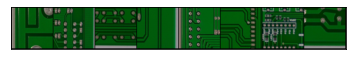

In [11]:
# sample check
sample, label = next(iter(train_loader))

# show grid image
def imshow_grid(img):
    img = torchvision.utils.make_grid(img)
    print(type(img))
    print(img.shape)
    plt.imshow(img.permute(1, 2, 0))
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.show()


imshow_grid(sample[0:8])

In [12]:
# load wandb
import wandb
wandb.init()
wandb.run.name = 'CONVAE_2000'

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [13]:
#cuda init
import gc
gc.collect()
torch.cuda.empty_cache()

In [4]:
"""
A Convolutional Variational Autoencoder
"""
class VAE(nn.Module):
    def __init__(self, imgChannels=3, featureDim=32*120*120, zDim=256):  #32 * (128-8 )*(128-8)iiji
        super(VAE, self).__init__()
        #encoder
        self.encConv1 = nn.Conv2d(imgChannels, 16, 5)
        self.encConv2 = nn.Conv2d(16, 32, 5)
        self.encFC1 = nn.Linear(featureDim, zDim)
        self.encFC2 = nn.Linear(featureDim, zDim)

        #decoder
        self.decFC1 = nn.Linear(zDim, featureDim)
        self.decConv1 = nn.ConvTranspose2d(32, 16, 5)
        self.decConv2 = nn.ConvTranspose2d(16, imgChannels, 5)

    def encoder(self, x):
        x = F.relu(self.encConv1(x))
        x = F.relu(self.encConv2(x))
        x = x.view(-1, 32*120*120) # 128-8
        mu = self.encFC1(x)  # 256
        logVar = self.encFC2(x)  # 256
        return mu, logVar

    def reparameterize(self, mu, logVar):

        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decoder(self, z):
        x = F.relu(self.decFC1(z)) #32 20 20
        x = x.view(-1, 32, 120, 120) # 128-8
        x = F.relu(self.decConv1(x)) # 32 16 5
        x = torch.sigmoid(self.decConv2(x)) # 16 3 5  
        return x  ##  1 deconv >> kernel +4 >> 2deconv Kernel +8

    def forward(self, x):
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        out = self.decoder(z)
        return out, mu, logVar

In [8]:

batch_size = 10
learning_rate = 1e-3
num_epochs = 2000



net = VAE().cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)


total_steps = len(train_loader)
for epoch in range(num_epochs):
    for idx, data in enumerate(train_loader, 0):

        imgs, _ = data
        imgs = imgs.cuda()

        out, mu, logVar = net(imgs)
        kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(out, imgs, size_average=False) + kl_divergence

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        wandb.log({
            "Test Loss": loss/(total_steps*10),
            "kl_divergence": kl_divergence/total_steps})

    print('Epoch {}: Loss {}'.format(epoch, loss))

/home/pojaehanwer/anaconda3/envs/VAECONV/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0: Loss 164622.0
Epoch 1: Loss 169199.828125
Epoch 2: Loss 163159.734375
Epoch 3: Loss 171035.25
Epoch 4: Loss 167471.6875
Epoch 5: Loss 162338.984375
Epoch 6: Loss 163061.359375
Epoch 7: Loss 150813.703125
Epoch 8: Loss 155561.6875
Epoch 9: Loss 154030.4375
Epoch 10: Loss 153518.40625
Epoch 11: Loss 140645.484375
Epoch 12: Loss 156683.390625
Epoch 13: Loss 147395.359375
Epoch 14: Loss 145637.421875
Epoch 15: Loss 149673.296875
Epoch 16: Loss 155975.03125
Epoch 17: Loss 142303.09375
Epoch 18: Loss 138068.765625
Epoch 19: Loss 138258.6875
Epoch 20: Loss 142013.1875
Epoch 21: Loss 137181.984375
Epoch 22: Loss 144950.6875
Epoch 23: Loss 150743.90625
Epoch 24: Loss 134931.796875
Epoch 25: Loss 138569.109375
Epoch 26: Loss 139197.21875
Epoch 27: Loss 138894.359375
Epoch 28: Loss 131962.046875
Epoch 29: Loss 138999.34375
Epoch 30: Loss 150487.3125
Epoch 31: Loss 136151.5
Epoch 32: Loss 140794.265625
Epoch 33: Loss 136759.859375
Epoch 34: Loss 133257.671875
Epoch 35: Loss 146145.25
Epoc

In [6]:
#save model
# net --> model name
current_time = datetime.datetime.now() + datetime.timedelta(hours= 9)
current_time = current_time.strftime('%Y-%m-%d-%H:%M')
saved_loc = os.path.join('./weight', current_time)
os.mkdir(saved_loc)

print("저장 위치: ", saved_loc)
print(net)
PATH = saved_loc + '/' #'/home/jaehan/vae_pytorch_custom/caveweight/'

torch.save(net, PATH + 'model.pt')
torch.save(net.state_dict(), PATH + 'model_state_dict.pt')  # 모델 객체의 state_dict 저장
torch.save({
    'model': net.state_dict(),
    'optimizer': optimizer.state_dict()
}, PATH + 'all.tar')  

FileExistsError: [Errno 17] File exists: './weight/2022-06-06-04:49'

In [7]:
#load model
net = VAE().cuda()

batch_size = 1
learning_rate = 1e-3
num_epochs = 10
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

PATH = '/home/pojaehanwer/Make_Conv_VAE/weight/2022-06-06-03:40/'
net = torch.load(PATH + 'model.pt')  # 전체 모델을 통째로 불러옴, 클래스 선언 필수
net.load_state_dict(torch.load(PATH + 'model_state_dict.pt'))  # state_dict를 불러 온 후, 모델에 저장

checkpoint = torch.load(PATH + 'all.tar')   # dict 불러오기
net.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

In [8]:
#test loader
os.getcwd()
transformer = transforms.Compose([
            transforms.Resize((128,128)),
            transforms.ToTensor()])
testset = torchvision.datasets.ImageFolder(root='/home/pojaehanwer/Downloads/DATASET_PCB/test/crop/New', transform = transformer)

test_loader = torch.utils.data.DataLoader(testset, batch_size = 1, shuffle = True, num_workers = 2)


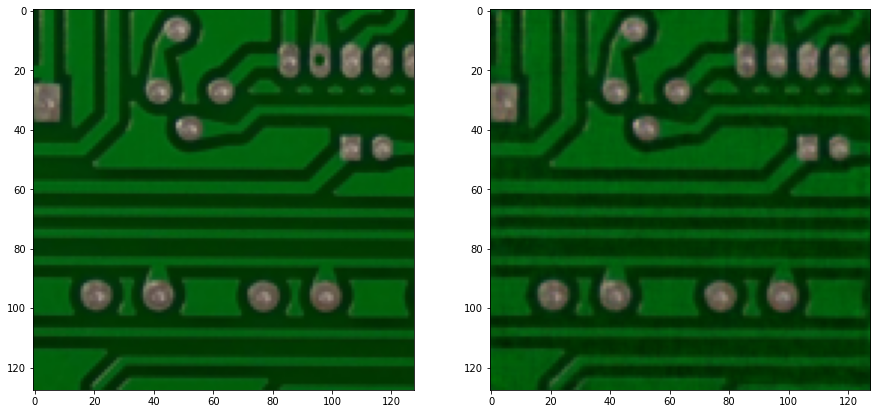

In [40]:
# make image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

plt.rcParams["figure.figsize"] = (15, 15)
net.eval()
with torch.no_grad():
    for data in random.sample(list(test_loader), 1):
        imgs, _ = data
        imgs = imgs.cuda()
        img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        plt.subplot(121)
        plt.imshow(np.squeeze(img))
        plt.imsave('img.png', img)

        out, mu, logVAR = net(imgs)
        outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        plt.subplot(122)
        plt.imshow(np.squeeze(outimg))
        plt.imsave('outimg.png', outimg)
        # cv2.imwrite("outimg.jpg", outimg)
        break

second


NameError: name 'thresh_filter' is not defined

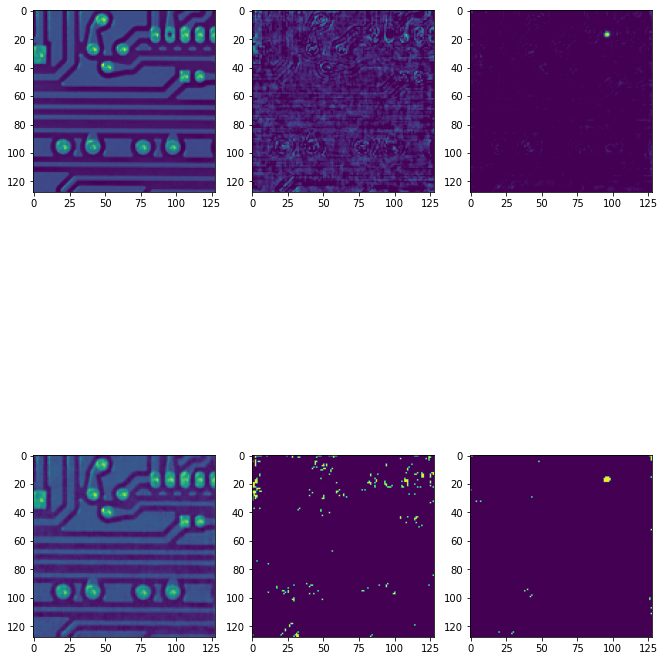

In [42]:
print("second")# subtract image all sub
import cv2
import numpy as np
import matplotlib.pyplot as plt
# print(img)
# plt.rcParams["figure.figsize"] = (15, 15)
img = cv2.imread('img.png', cv2.IMREAD_GRAYSCALE)
outimg = cv2.imread('outimg.png', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('./result_1/epoch2000/imgOC.jpg', cv2.IMREAD_GRAYSCALE)
# outimg = cv2.imread('./result_1/epoch2000/outimgOC.jpg', cv2.IMREAD_GRAYSCALE)

# print(img)
plt.subplot(241)
plt.imshow(img)
plt.subplot(245)
plt.imshow(outimg)

sub_oi = cv2.subtract(outimg, img)
sub_io = cv2.subtract(img, outimg)

thresh_n = 10
thresh_oi = np.zeros_like(sub_oi) 
thresh_oi[sub_oi > thresh_n] = 255
thresh_io = np.zeros_like(sub_io) 
thresh_io[sub_io > thresh_n] = 255

plt.subplot(242)
plt.imshow(sub_io)
plt.subplot(243)
plt.imshow(sub_oi)
plt.subplot(246)
plt.imshow(thresh_io)
plt.subplot(247)
plt.imshow(thresh_oi)

thresh_sum = thresh_io + thresh_oi
thresh_sum = cv2.medianBlur(thresh_sum, ksize = 3)
plt.subplot(247)
plt.imshow(thresh_filter)
plt.subplots_adjust(left=0.125, bottom=0.5,  right=0.9, top=0.9, wspace=0.2, hspace=0)
plt.subplot(244)
plt.imshow(thresh_sum)

plt.imsave('thresh_np.jpg', thresh_np)
# print(thresh_np.shape)

In [32]:
import matplotlib.pyplot as plt


error: OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/highgui/src/window.cpp:632: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Carbon support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'
